In [1]:
import os
import sys

sys.path.insert(0, "../../")

import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)

import pandas as pd
import warnings


warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.set_option('display.max_columns', None)
import pathlib

from lips.benchmark.powergridBenchmark import PowerGridBenchmark
from lips.augmented_simulators.tensorflow_models import LeapNet
from lips.dataset.scaler.powergrid_scaler import PowerGridScaler

from lips.config import ConfigManager
from lips.utils import get_path

# 1. l2rpn_neurips_2020_track1_small grid

In [2]:
# indicate required paths
LIPS_PATH = pathlib.Path().resolve().parent.parent # it is supposed that the notebook had run from getting_started folder
DATA_PATH = LIPS_PATH / "reference_data" / "powergrid" / "l2rpn_neurips_2020_track1_small"
BENCH_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "benchmarks" / "l2rpn_neurips_2020_track1_small.ini"
SIM_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "simulators"
BASELINES_PATH = LIPS_PATH / "trained_baselines" / "powergrid"
TRAINED_BASELINES_PATH = LIPS_PATH / "trained_baselines" / "powergrid"
EVALUATION_PATH = LIPS_PATH / "evaluation_results" / "PowerGrid"
LOG_PATH = LIPS_PATH / "lips_logs.log"

## 1.1 Benchmark1: Risk assessment through contingency screening

In [3]:
benchmark1 = PowerGridBenchmark(benchmark_name="Benchmark1",
                                benchmark_path=DATA_PATH,
                                load_data_set=True,
                                log_path=LOG_PATH,
                                config_path=BENCH_CONFIG_PATH
                               )

In [4]:
bench_config = ConfigManager(section_name="Benchmark1", path=BENCH_CONFIG_PATH)
topo_actions = bench_config.get_option("dataset_create_params")["reference_args"]["topo_actions"]

kwargs_tau = []
for el in topo_actions:
     kwargs_tau.append(el["set_bus"]["substations_id"][0])

kwargs_tau

[(1, (2, 2, 1, 1, 2, 2)),
 (16, (1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1)),
 (16, (1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)),
 (28, (2, 1, 2, 1, 1))]

## LeapNet

In this benchmark, we add the topo_vect as input and we inject only the line_status in tau. To do this, go to the benchmark config file, add topo_vect in the input attributes and don't forget to remove it from the tau attributes

In [5]:
leap_net1 = LeapNet(name="tf_leapnet",
                   bench_config_path=BENCH_CONFIG_PATH,
                   bench_config_name="Benchmark1",
                   sim_config_path=SIM_CONFIG_PATH / "tf_leapnet.ini",
                   sim_config_name="DEFAULT",
                    
                   sizes_enc=(),
                   sizes_main=(400, 400),
                   sizes_out=(),
                   topo_vect_to_tau="given_list",
                   kwargs_tau = kwargs_tau,
                    
                   loss = {"name": "mse"},
                   lr = 1e-4,
                   layer = "resnet",
                   activation = tf.keras.layers.LeakyReLU(alpha=0.01),
                    
                   scale_main_layer = 400,
                   scale_input_dec_layer = 400,
                   
                   log_path=LOG_PATH,
                   
                   mult_by_zero_lines_pred = False,
                    
                   scaler = PowerGridScaler
                   )

In [6]:
import time
start_time = time.time()

In [7]:
leap_net1.train(train_dataset=benchmark1.train_dataset,
                val_dataset=benchmark1.val_dataset,
                batch_size = 128,
                epochs = 800)

2022-07-22 14:10:13.855332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-22 14:10:14.264677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5120 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:83:00.0, compute capability: 8.6


Epoch 1/800
  34/1172 [..............................] - ETA: 5s - loss: 5.6970 - a_or_hat_loss: 2.8058 - a_ex_hat_loss: 2.8913 - a_or_hat_mae: 1.2437 - a_ex_hat_mae: 1.2629 

2022-07-22 14:15:36.531420: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1172/1172 [==============================] - 8s 6ms/step - loss: 0.4410 - a_or_hat_loss: 0.2209 - a_ex_hat_loss: 0.2201 - a_or_hat_mae: 0.2562 - a_ex_hat_mae: 0.2543 - val_loss: 0.1339 - val_a_or_hat_loss: 0.0684 - val_a_ex_hat_loss: 0.0655 - val_a_or_hat_mae: 0.1557 - val_a_ex_hat_mae: 0.1546
Epoch 2/800
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0730 - a_or_hat_loss: 0.0377 - a_ex_hat_loss: 0.0353 - a_or_hat_mae: 0.1170 - a_ex_hat_mae: 0.1139 - val_loss: 0.0680 - val_a_or_hat_loss: 0.0356 - val_a_ex_hat_loss: 0.0325 - val_a_or_hat_mae: 0.1128 - val_a_ex_hat_mae: 0.1073
Epoch 3/800
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0417 - a_or_hat_loss: 0.0216 - a_ex_hat_loss: 0.0201 - a_or_hat_mae: 0.0891 - a_ex_hat_mae: 0.0863 - val_loss: 0.0465 - val_a_or_hat_loss: 0.0242 - val_a_ex_hat_loss: 0.0223 - val_a_or_hat_mae: 0.0910 - val_a_ex_hat_mae: 0.0869
Epoch 4/800
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0303 - a_or_

Epoch 28/800
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0059 - a_or_hat_loss: 0.0030 - a_ex_hat_loss: 0.0029 - a_or_hat_mae: 0.0341 - a_ex_hat_mae: 0.0333 - val_loss: 0.0091 - val_a_or_hat_loss: 0.0046 - val_a_ex_hat_loss: 0.0045 - val_a_or_hat_mae: 0.0399 - val_a_ex_hat_mae: 0.0391
Epoch 29/800
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0058 - a_or_hat_loss: 0.0029 - a_ex_hat_loss: 0.0029 - a_or_hat_mae: 0.0337 - a_ex_hat_mae: 0.0330 - val_loss: 0.0112 - val_a_or_hat_loss: 0.0056 - val_a_ex_hat_loss: 0.0056 - val_a_or_hat_mae: 0.0453 - val_a_ex_hat_mae: 0.0449
Epoch 30/800
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0057 - a_or_hat_loss: 0.0029 - a_ex_hat_loss: 0.0028 - a_or_hat_mae: 0.0335 - a_ex_hat_mae: 0.0327 - val_loss: 0.0090 - val_a_or_hat_loss: 0.0046 - val_a_ex_hat_loss: 0.0044 - val_a_or_hat_mae: 0.0404 - val_a_ex_hat_mae: 0.0387
Epoch 31/800
1172/1172 [==============================] - 6s 5ms/step - loss

Epoch 55/800
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0039 - a_or_hat_loss: 0.0020 - a_ex_hat_loss: 0.0019 - a_or_hat_mae: 0.0275 - a_ex_hat_mae: 0.0269 - val_loss: 0.0061 - val_a_or_hat_loss: 0.0031 - val_a_ex_hat_loss: 0.0030 - val_a_or_hat_mae: 0.0314 - val_a_ex_hat_mae: 0.0308
Epoch 56/800
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0039 - a_or_hat_loss: 0.0020 - a_ex_hat_loss: 0.0019 - a_or_hat_mae: 0.0278 - a_ex_hat_mae: 0.0271 - val_loss: 0.0063 - val_a_or_hat_loss: 0.0033 - val_a_ex_hat_loss: 0.0030 - val_a_or_hat_mae: 0.0337 - val_a_ex_hat_mae: 0.0315
Epoch 57/800
1172/1172 [==============================] - 6s 6ms/step - loss: 0.0040 - a_or_hat_loss: 0.0020 - a_ex_hat_loss: 0.0019 - a_or_hat_mae: 0.0279 - a_ex_hat_mae: 0.0273 - val_loss: 0.0070 - val_a_or_hat_loss: 0.0036 - val_a_ex_hat_loss: 0.0034 - val_a_or_hat_mae: 0.0341 - val_a_ex_hat_mae: 0.0326
Epoch 58/800
1172/1172 [==============================] - 6s 6ms/step - loss

Epoch 82/800
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0030 - a_or_hat_loss: 0.0016 - a_ex_hat_loss: 0.0015 - a_or_hat_mae: 0.0248 - a_ex_hat_mae: 0.0240 - val_loss: 0.0050 - val_a_or_hat_loss: 0.0026 - val_a_ex_hat_loss: 0.0024 - val_a_or_hat_mae: 0.0291 - val_a_ex_hat_mae: 0.0282
Epoch 83/800
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0030 - a_or_hat_loss: 0.0015 - a_ex_hat_loss: 0.0014 - a_or_hat_mae: 0.0248 - a_ex_hat_mae: 0.0241 - val_loss: 0.0049 - val_a_or_hat_loss: 0.0025 - val_a_ex_hat_loss: 0.0024 - val_a_or_hat_mae: 0.0283 - val_a_ex_hat_mae: 0.0276
Epoch 84/800
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0031 - a_or_hat_loss: 0.0016 - a_ex_hat_loss: 0.0015 - a_or_hat_mae: 0.0251 - a_ex_hat_mae: 0.0243 - val_loss: 0.0047 - val_a_or_hat_loss: 0.0024 - val_a_ex_hat_loss: 0.0023 - val_a_or_hat_mae: 0.0283 - val_a_ex_hat_mae: 0.0270
Epoch 85/800
1172/1172 [==============================] - 6s 5ms/step - loss

Epoch 109/800
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0028 - a_or_hat_loss: 0.0014 - a_ex_hat_loss: 0.0014 - a_or_hat_mae: 0.0235 - a_ex_hat_mae: 0.0230 - val_loss: 0.0043 - val_a_or_hat_loss: 0.0022 - val_a_ex_hat_loss: 0.0021 - val_a_or_hat_mae: 0.0267 - val_a_ex_hat_mae: 0.0259
Epoch 110/800
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0024 - a_or_hat_loss: 0.0012 - a_ex_hat_loss: 0.0012 - a_or_hat_mae: 0.0219 - a_ex_hat_mae: 0.0214 - val_loss: 0.0041 - val_a_or_hat_loss: 0.0021 - val_a_ex_hat_loss: 0.0020 - val_a_or_hat_mae: 0.0263 - val_a_ex_hat_mae: 0.0253
Epoch 111/800
1172/1172 [==============================] - 6s 6ms/step - loss: 0.0024 - a_or_hat_loss: 0.0012 - a_ex_hat_loss: 0.0012 - a_or_hat_mae: 0.0225 - a_ex_hat_mae: 0.0220 - val_loss: 0.0042 - val_a_or_hat_loss: 0.0021 - val_a_ex_hat_loss: 0.0021 - val_a_or_hat_mae: 0.0264 - val_a_ex_hat_mae: 0.0257
Epoch 112/800
1172/1172 [==============================] - 6s 5ms/step - 

1172/1172 [==============================] - 6s 6ms/step - loss: 0.0020 - a_or_hat_loss: 0.0010 - a_ex_hat_loss: 9.9118e-04 - a_or_hat_mae: 0.0204 - a_ex_hat_mae: 0.0200 - val_loss: 0.0035 - val_a_or_hat_loss: 0.0018 - val_a_ex_hat_loss: 0.0018 - val_a_or_hat_mae: 0.0238 - val_a_ex_hat_mae: 0.0237
Epoch 162/800
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0021 - a_or_hat_loss: 0.0010 - a_ex_hat_loss: 0.0010 - a_or_hat_mae: 0.0207 - a_ex_hat_mae: 0.0203 - val_loss: 0.0050 - val_a_or_hat_loss: 0.0025 - val_a_ex_hat_loss: 0.0025 - val_a_or_hat_mae: 0.0295 - val_a_ex_hat_mae: 0.0293
Epoch 163/800
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0020 - a_or_hat_loss: 0.0010 - a_ex_hat_loss: 9.8790e-04 - a_or_hat_mae: 0.0202 - a_ex_hat_mae: 0.0198 - val_loss: 0.0035 - val_a_or_hat_loss: 0.0018 - val_a_ex_hat_loss: 0.0018 - val_a_or_hat_mae: 0.0235 - val_a_ex_hat_mae: 0.0232
Epoch 164/800
1172/1172 [==============================] - 6s 5ms/step - loss: 

1172/1172 [==============================] - 6s 5ms/step - loss: 0.0018 - a_or_hat_loss: 9.3442e-04 - a_ex_hat_loss: 9.1332e-04 - a_or_hat_mae: 0.0195 - a_ex_hat_mae: 0.0192 - val_loss: 0.0031 - val_a_or_hat_loss: 0.0016 - val_a_ex_hat_loss: 0.0015 - val_a_or_hat_mae: 0.0217 - val_a_ex_hat_mae: 0.0215
Epoch 188/800
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0018 - a_or_hat_loss: 8.8309e-04 - a_ex_hat_loss: 8.6814e-04 - a_or_hat_mae: 0.0189 - a_ex_hat_mae: 0.0186 - val_loss: 0.0032 - val_a_or_hat_loss: 0.0016 - val_a_ex_hat_loss: 0.0016 - val_a_or_hat_mae: 0.0232 - val_a_ex_hat_mae: 0.0220
Epoch 189/800
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0019 - a_or_hat_loss: 9.3647e-04 - a_ex_hat_loss: 9.1853e-04 - a_or_hat_mae: 0.0196 - a_ex_hat_mae: 0.0193 - val_loss: 0.0032 - val_a_or_hat_loss: 0.0016 - val_a_ex_hat_loss: 0.0016 - val_a_or_hat_mae: 0.0228 - val_a_ex_hat_mae: 0.0223
Epoch 190/800
1172/1172 [==============================] - 6s 5

Epoch 213/800
1172/1172 [==============================] - 6s 6ms/step - loss: 0.0017 - a_or_hat_loss: 8.5306e-04 - a_ex_hat_loss: 8.3291e-04 - a_or_hat_mae: 0.0186 - a_ex_hat_mae: 0.0182 - val_loss: 0.0035 - val_a_or_hat_loss: 0.0017 - val_a_ex_hat_loss: 0.0017 - val_a_or_hat_mae: 0.0247 - val_a_ex_hat_mae: 0.0249
Epoch 214/800
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0017 - a_or_hat_loss: 8.7552e-04 - a_ex_hat_loss: 8.5285e-04 - a_or_hat_mae: 0.0189 - a_ex_hat_mae: 0.0186 - val_loss: 0.0030 - val_a_or_hat_loss: 0.0015 - val_a_ex_hat_loss: 0.0015 - val_a_or_hat_mae: 0.0220 - val_a_ex_hat_mae: 0.0214
Epoch 215/800
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0017 - a_or_hat_loss: 8.3431e-04 - a_ex_hat_loss: 8.1784e-04 - a_or_hat_mae: 0.0183 - a_ex_hat_mae: 0.0180 - val_loss: 0.0029 - val_a_or_hat_loss: 0.0015 - val_a_ex_hat_loss: 0.0014 - val_a_or_hat_mae: 0.0212 - val_a_ex_hat_mae: 0.0202
Epoch 216/800
1172/1172 [========================

Epoch 239/800
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0016 - a_or_hat_loss: 7.9965e-04 - a_ex_hat_loss: 7.7483e-04 - a_or_hat_mae: 0.0180 - a_ex_hat_mae: 0.0177 - val_loss: 0.0027 - val_a_or_hat_loss: 0.0014 - val_a_ex_hat_loss: 0.0013 - val_a_or_hat_mae: 0.0198 - val_a_ex_hat_mae: 0.0196
Epoch 240/800
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0016 - a_or_hat_loss: 7.8876e-04 - a_ex_hat_loss: 7.6275e-04 - a_or_hat_mae: 0.0179 - a_ex_hat_mae: 0.0175 - val_loss: 0.0028 - val_a_or_hat_loss: 0.0014 - val_a_ex_hat_loss: 0.0014 - val_a_or_hat_mae: 0.0207 - val_a_ex_hat_mae: 0.0200
Epoch 241/800
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0016 - a_or_hat_loss: 8.1979e-04 - a_ex_hat_loss: 7.9609e-04 - a_or_hat_mae: 0.0183 - a_ex_hat_mae: 0.0179 - val_loss: 0.0029 - val_a_or_hat_loss: 0.0015 - val_a_ex_hat_loss: 0.0014 - val_a_or_hat_mae: 0.0212 - val_a_ex_hat_mae: 0.0210
Epoch 242/800
1172/1172 [========================

Epoch 265/800
1172/1172 [==============================] - 6s 6ms/step - loss: 0.0016 - a_or_hat_loss: 7.9247e-04 - a_ex_hat_loss: 7.6178e-04 - a_or_hat_mae: 0.0177 - a_ex_hat_mae: 0.0173 - val_loss: 0.0029 - val_a_or_hat_loss: 0.0015 - val_a_ex_hat_loss: 0.0014 - val_a_or_hat_mae: 0.0218 - val_a_ex_hat_mae: 0.0209
Epoch 266/800
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0014 - a_or_hat_loss: 7.2794e-04 - a_ex_hat_loss: 7.0174e-04 - a_or_hat_mae: 0.0171 - a_ex_hat_mae: 0.0168 - val_loss: 0.0027 - val_a_or_hat_loss: 0.0014 - val_a_ex_hat_loss: 0.0013 - val_a_or_hat_mae: 0.0200 - val_a_ex_hat_mae: 0.0196
Epoch 267/800
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0014 - a_or_hat_loss: 7.1341e-04 - a_ex_hat_loss: 6.9204e-04 - a_or_hat_mae: 0.0170 - a_ex_hat_mae: 0.0167 - val_loss: 0.0033 - val_a_or_hat_loss: 0.0017 - val_a_ex_hat_loss: 0.0016 - val_a_or_hat_mae: 0.0233 - val_a_ex_hat_mae: 0.0227
Epoch 268/800
1172/1172 [========================

Epoch 291/800
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0014 - a_or_hat_loss: 6.9555e-04 - a_ex_hat_loss: 6.7090e-04 - a_or_hat_mae: 0.0168 - a_ex_hat_mae: 0.0164 - val_loss: 0.0027 - val_a_or_hat_loss: 0.0013 - val_a_ex_hat_loss: 0.0013 - val_a_or_hat_mae: 0.0197 - val_a_ex_hat_mae: 0.0193
Epoch 292/800
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0014 - a_or_hat_loss: 7.1368e-04 - a_ex_hat_loss: 6.8553e-04 - a_or_hat_mae: 0.0170 - a_ex_hat_mae: 0.0166 - val_loss: 0.0026 - val_a_or_hat_loss: 0.0013 - val_a_ex_hat_loss: 0.0013 - val_a_or_hat_mae: 0.0197 - val_a_ex_hat_mae: 0.0195
Epoch 293/800
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0014 - a_or_hat_loss: 7.0351e-04 - a_ex_hat_loss: 6.7703e-04 - a_or_hat_mae: 0.0169 - a_ex_hat_mae: 0.0165 - val_loss: 0.0027 - val_a_or_hat_loss: 0.0014 - val_a_ex_hat_loss: 0.0013 - val_a_or_hat_mae: 0.0197 - val_a_ex_hat_mae: 0.0194
Epoch 294/800
1172/1172 [========================

Epoch 317/800
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0014 - a_or_hat_loss: 6.9749e-04 - a_ex_hat_loss: 6.7143e-04 - a_or_hat_mae: 0.0169 - a_ex_hat_mae: 0.0164 - val_loss: 0.0026 - val_a_or_hat_loss: 0.0013 - val_a_ex_hat_loss: 0.0013 - val_a_or_hat_mae: 0.0190 - val_a_ex_hat_mae: 0.0190
Epoch 318/800
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0013 - a_or_hat_loss: 6.7016e-04 - a_ex_hat_loss: 6.4425e-04 - a_or_hat_mae: 0.0163 - a_ex_hat_mae: 0.0160 - val_loss: 0.0026 - val_a_or_hat_loss: 0.0013 - val_a_ex_hat_loss: 0.0013 - val_a_or_hat_mae: 0.0196 - val_a_ex_hat_mae: 0.0193
Epoch 319/800
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0013 - a_or_hat_loss: 6.4922e-04 - a_ex_hat_loss: 6.2337e-04 - a_or_hat_mae: 0.0163 - a_ex_hat_mae: 0.0159 - val_loss: 0.0035 - val_a_or_hat_loss: 0.0018 - val_a_ex_hat_loss: 0.0017 - val_a_or_hat_mae: 0.0257 - val_a_ex_hat_mae: 0.0243
Epoch 320/800
1172/1172 [========================

Epoch 343/800
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0013 - a_or_hat_loss: 6.6464e-04 - a_ex_hat_loss: 6.4445e-04 - a_or_hat_mae: 0.0163 - a_ex_hat_mae: 0.0160 - val_loss: 0.0024 - val_a_or_hat_loss: 0.0012 - val_a_ex_hat_loss: 0.0012 - val_a_or_hat_mae: 0.0185 - val_a_ex_hat_mae: 0.0179
Epoch 344/800
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0012 - a_or_hat_loss: 5.9930e-04 - a_ex_hat_loss: 5.7451e-04 - a_or_hat_mae: 0.0155 - a_ex_hat_mae: 0.0151 - val_loss: 0.0027 - val_a_or_hat_loss: 0.0014 - val_a_ex_hat_loss: 0.0013 - val_a_or_hat_mae: 0.0194 - val_a_ex_hat_mae: 0.0195
Epoch 345/800
1172/1172 [==============================] - 6s 6ms/step - loss: 0.0013 - a_or_hat_loss: 6.5034e-04 - a_ex_hat_loss: 6.2208e-04 - a_or_hat_mae: 0.0163 - a_ex_hat_mae: 0.0159 - val_loss: 0.0026 - val_a_or_hat_loss: 0.0014 - val_a_ex_hat_loss: 0.0013 - val_a_or_hat_mae: 0.0209 - val_a_ex_hat_mae: 0.0194
Epoch 346/800
1172/1172 [========================

Epoch 369/800
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0012 - a_or_hat_loss: 6.0586e-04 - a_ex_hat_loss: 5.7982e-04 - a_or_hat_mae: 0.0156 - a_ex_hat_mae: 0.0153 - val_loss: 0.0024 - val_a_or_hat_loss: 0.0012 - val_a_ex_hat_loss: 0.0012 - val_a_or_hat_mae: 0.0187 - val_a_ex_hat_mae: 0.0181
Epoch 370/800
1172/1172 [==============================] - 6s 6ms/step - loss: 0.0012 - a_or_hat_loss: 6.3097e-04 - a_ex_hat_loss: 6.0240e-04 - a_or_hat_mae: 0.0160 - a_ex_hat_mae: 0.0156 - val_loss: 0.0025 - val_a_or_hat_loss: 0.0013 - val_a_ex_hat_loss: 0.0013 - val_a_or_hat_mae: 0.0185 - val_a_ex_hat_mae: 0.0185
Epoch 371/800
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0012 - a_or_hat_loss: 6.3169e-04 - a_ex_hat_loss: 6.0254e-04 - a_or_hat_mae: 0.0158 - a_ex_hat_mae: 0.0154 - val_loss: 0.0024 - val_a_or_hat_loss: 0.0012 - val_a_ex_hat_loss: 0.0012 - val_a_or_hat_mae: 0.0181 - val_a_ex_hat_mae: 0.0176
Epoch 372/800
1172/1172 [========================

Epoch 395/800
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0012 - a_or_hat_loss: 6.0566e-04 - a_ex_hat_loss: 5.7647e-04 - a_or_hat_mae: 0.0157 - a_ex_hat_mae: 0.0152 - val_loss: 0.0023 - val_a_or_hat_loss: 0.0012 - val_a_ex_hat_loss: 0.0011 - val_a_or_hat_mae: 0.0177 - val_a_ex_hat_mae: 0.0175
Epoch 396/800
1172/1172 [==============================] - 6s 6ms/step - loss: 0.0012 - a_or_hat_loss: 6.1816e-04 - a_ex_hat_loss: 5.9097e-04 - a_or_hat_mae: 0.0158 - a_ex_hat_mae: 0.0154 - val_loss: 0.0023 - val_a_or_hat_loss: 0.0012 - val_a_ex_hat_loss: 0.0011 - val_a_or_hat_mae: 0.0177 - val_a_ex_hat_mae: 0.0172
Epoch 397/800
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0012 - a_or_hat_loss: 6.0816e-04 - a_ex_hat_loss: 5.7973e-04 - a_or_hat_mae: 0.0156 - a_ex_hat_mae: 0.0152 - val_loss: 0.0025 - val_a_or_hat_loss: 0.0013 - val_a_ex_hat_loss: 0.0012 - val_a_or_hat_mae: 0.0184 - val_a_ex_hat_mae: 0.0178
Epoch 398/800
1172/1172 [========================

Epoch 421/800
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0011 - a_or_hat_loss: 5.6394e-04 - a_ex_hat_loss: 5.3746e-04 - a_or_hat_mae: 0.0152 - a_ex_hat_mae: 0.0148 - val_loss: 0.0022 - val_a_or_hat_loss: 0.0012 - val_a_ex_hat_loss: 0.0011 - val_a_or_hat_mae: 0.0178 - val_a_ex_hat_mae: 0.0171
Epoch 422/800
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0011 - a_or_hat_loss: 5.6573e-04 - a_ex_hat_loss: 5.3881e-04 - a_or_hat_mae: 0.0152 - a_ex_hat_mae: 0.0148 - val_loss: 0.0024 - val_a_or_hat_loss: 0.0012 - val_a_ex_hat_loss: 0.0011 - val_a_or_hat_mae: 0.0184 - val_a_ex_hat_mae: 0.0179
Epoch 423/800
1172/1172 [==============================] - 6s 6ms/step - loss: 0.0012 - a_or_hat_loss: 6.1920e-04 - a_ex_hat_loss: 5.8823e-04 - a_or_hat_mae: 0.0159 - a_ex_hat_mae: 0.0154 - val_loss: 0.0024 - val_a_or_hat_loss: 0.0012 - val_a_ex_hat_loss: 0.0011 - val_a_or_hat_mae: 0.0191 - val_a_ex_hat_mae: 0.0182
Epoch 424/800
1172/1172 [========================

Epoch 447/800
1172/1172 [==============================] - 6s 6ms/step - loss: 0.0011 - a_or_hat_loss: 5.5790e-04 - a_ex_hat_loss: 5.2746e-04 - a_or_hat_mae: 0.0150 - a_ex_hat_mae: 0.0146 - val_loss: 0.0024 - val_a_or_hat_loss: 0.0012 - val_a_ex_hat_loss: 0.0012 - val_a_or_hat_mae: 0.0187 - val_a_ex_hat_mae: 0.0184
Epoch 448/800
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0011 - a_or_hat_loss: 5.4719e-04 - a_ex_hat_loss: 5.1804e-04 - a_or_hat_mae: 0.0149 - a_ex_hat_mae: 0.0145 - val_loss: 0.0022 - val_a_or_hat_loss: 0.0011 - val_a_ex_hat_loss: 0.0011 - val_a_or_hat_mae: 0.0172 - val_a_ex_hat_mae: 0.0164
Epoch 449/800
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0011 - a_or_hat_loss: 5.4665e-04 - a_ex_hat_loss: 5.2297e-04 - a_or_hat_mae: 0.0149 - a_ex_hat_mae: 0.0145 - val_loss: 0.0022 - val_a_or_hat_loss: 0.0012 - val_a_ex_hat_loss: 0.0011 - val_a_or_hat_mae: 0.0183 - val_a_ex_hat_mae: 0.0174
Epoch 450/800
1172/1172 [========================

Epoch 473/800
1172/1172 [==============================] - 7s 6ms/step - loss: 9.9517e-04 - a_or_hat_loss: 5.0937e-04 - a_ex_hat_loss: 4.8581e-04 - a_or_hat_mae: 0.0142 - a_ex_hat_mae: 0.0139 - val_loss: 0.0024 - val_a_or_hat_loss: 0.0012 - val_a_ex_hat_loss: 0.0011 - val_a_or_hat_mae: 0.0183 - val_a_ex_hat_mae: 0.0177
Epoch 474/800
1172/1172 [==============================] - 7s 6ms/step - loss: 9.8936e-04 - a_or_hat_loss: 5.0593e-04 - a_ex_hat_loss: 4.8343e-04 - a_or_hat_mae: 0.0143 - a_ex_hat_mae: 0.0139 - val_loss: 0.0022 - val_a_or_hat_loss: 0.0011 - val_a_ex_hat_loss: 0.0011 - val_a_or_hat_mae: 0.0167 - val_a_ex_hat_mae: 0.0165
Epoch 475/800
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0010 - a_or_hat_loss: 5.1679e-04 - a_ex_hat_loss: 4.8997e-04 - a_or_hat_mae: 0.0146 - a_ex_hat_mae: 0.0141 - val_loss: 0.0024 - val_a_or_hat_loss: 0.0012 - val_a_ex_hat_loss: 0.0012 - val_a_or_hat_mae: 0.0191 - val_a_ex_hat_mae: 0.0192
Epoch 476/800
1172/1172 [================

Epoch 499/800
1172/1172 [==============================] - 6s 5ms/step - loss: 0.0011 - a_or_hat_loss: 5.7347e-04 - a_ex_hat_loss: 5.4165e-04 - a_or_hat_mae: 0.0152 - a_ex_hat_mae: 0.0148 - val_loss: 0.0021 - val_a_or_hat_loss: 0.0010 - val_a_ex_hat_loss: 0.0010 - val_a_or_hat_mae: 0.0163 - val_a_ex_hat_mae: 0.0163
Epoch 500/800
1172/1172 [==============================] - 7s 6ms/step - loss: 0.0010 - a_or_hat_loss: 5.2590e-04 - a_ex_hat_loss: 4.9992e-04 - a_or_hat_mae: 0.0146 - a_ex_hat_mae: 0.0142 - val_loss: 0.0023 - val_a_or_hat_loss: 0.0012 - val_a_ex_hat_loss: 0.0011 - val_a_or_hat_mae: 0.0179 - val_a_ex_hat_mae: 0.0173
Epoch 501/800
1172/1172 [==============================] - 7s 6ms/step - loss: 9.8839e-04 - a_or_hat_loss: 5.0619e-04 - a_ex_hat_loss: 4.8220e-04 - a_or_hat_mae: 0.0143 - a_ex_hat_mae: 0.0139 - val_loss: 0.0021 - val_a_or_hat_loss: 0.0011 - val_a_ex_hat_loss: 0.0010 - val_a_or_hat_mae: 0.0170 - val_a_ex_hat_mae: 0.0167
Epoch 502/800
1172/1172 [====================

Epoch 525/800
1172/1172 [==============================] - 7s 6ms/step - loss: 9.6087e-04 - a_or_hat_loss: 4.9228e-04 - a_ex_hat_loss: 4.6859e-04 - a_or_hat_mae: 0.0141 - a_ex_hat_mae: 0.0138 - val_loss: 0.0021 - val_a_or_hat_loss: 0.0011 - val_a_ex_hat_loss: 0.0010 - val_a_or_hat_mae: 0.0171 - val_a_ex_hat_mae: 0.0163
Epoch 526/800
1172/1172 [==============================] - 7s 6ms/step - loss: 9.6313e-04 - a_or_hat_loss: 4.9261e-04 - a_ex_hat_loss: 4.7052e-04 - a_or_hat_mae: 0.0142 - a_ex_hat_mae: 0.0138 - val_loss: 0.0021 - val_a_or_hat_loss: 0.0011 - val_a_ex_hat_loss: 0.0010 - val_a_or_hat_mae: 0.0166 - val_a_ex_hat_mae: 0.0161
Epoch 527/800
1172/1172 [==============================] - 7s 6ms/step - loss: 9.5731e-04 - a_or_hat_loss: 4.9006e-04 - a_ex_hat_loss: 4.6726e-04 - a_or_hat_mae: 0.0142 - a_ex_hat_mae: 0.0138 - val_loss: 0.0026 - val_a_or_hat_loss: 0.0013 - val_a_ex_hat_loss: 0.0013 - val_a_or_hat_mae: 0.0201 - val_a_ex_hat_mae: 0.0196
Epoch 528/800
1172/1172 [============

1172/1172 [==============================] - 7s 6ms/step - loss: 9.3530e-04 - a_or_hat_loss: 4.7824e-04 - a_ex_hat_loss: 4.5706e-04 - a_or_hat_mae: 0.0140 - a_ex_hat_mae: 0.0136 - val_loss: 0.0021 - val_a_or_hat_loss: 0.0011 - val_a_ex_hat_loss: 0.0010 - val_a_or_hat_mae: 0.0166 - val_a_ex_hat_mae: 0.0167
Epoch 576/800
1172/1172 [==============================] - 7s 6ms/step - loss: 9.6170e-04 - a_or_hat_loss: 4.9170e-04 - a_ex_hat_loss: 4.6999e-04 - a_or_hat_mae: 0.0142 - a_ex_hat_mae: 0.0138 - val_loss: 0.0020 - val_a_or_hat_loss: 0.0010 - val_a_ex_hat_loss: 9.8907e-04 - val_a_or_hat_mae: 0.0165 - val_a_ex_hat_mae: 0.0157
Epoch 577/800
1172/1172 [==============================] - 7s 6ms/step - loss: 9.3283e-04 - a_or_hat_loss: 4.7683e-04 - a_ex_hat_loss: 4.5599e-04 - a_or_hat_mae: 0.0139 - a_ex_hat_mae: 0.0136 - val_loss: 0.0021 - val_a_or_hat_loss: 0.0010 - val_a_ex_hat_loss: 0.0010 - val_a_or_hat_mae: 0.0163 - val_a_ex_hat_mae: 0.0161
Epoch 578/800
1172/1172 [======================

1172/1172 [==============================] - 7s 6ms/step - loss: 0.0011 - a_or_hat_loss: 5.7519e-04 - a_ex_hat_loss: 5.4416e-04 - a_or_hat_mae: 0.0149 - a_ex_hat_mae: 0.0145 - val_loss: 0.0021 - val_a_or_hat_loss: 0.0011 - val_a_ex_hat_loss: 0.0010 - val_a_or_hat_mae: 0.0165 - val_a_ex_hat_mae: 0.0159
Epoch 626/800
1172/1172 [==============================] - 7s 6ms/step - loss: 8.4240e-04 - a_or_hat_loss: 4.3066e-04 - a_ex_hat_loss: 4.1174e-04 - a_or_hat_mae: 0.0129 - a_ex_hat_mae: 0.0126 - val_loss: 0.0020 - val_a_or_hat_loss: 0.0010 - val_a_ex_hat_loss: 9.9447e-04 - val_a_or_hat_mae: 0.0161 - val_a_ex_hat_mae: 0.0158
Epoch 627/800
1172/1172 [==============================] - 7s 6ms/step - loss: 8.7787e-04 - a_or_hat_loss: 4.4899e-04 - a_ex_hat_loss: 4.2888e-04 - a_or_hat_mae: 0.0135 - a_ex_hat_mae: 0.0131 - val_loss: 0.0020 - val_a_or_hat_loss: 0.0010 - val_a_ex_hat_loss: 9.9374e-04 - val_a_or_hat_mae: 0.0159 - val_a_ex_hat_mae: 0.0158
Epoch 628/800
1172/1172 [======================

1172/1172 [==============================] - 7s 6ms/step - loss: 8.8861e-04 - a_or_hat_loss: 4.5475e-04 - a_ex_hat_loss: 4.3387e-04 - a_or_hat_mae: 0.0136 - a_ex_hat_mae: 0.0133 - val_loss: 0.0022 - val_a_or_hat_loss: 0.0011 - val_a_ex_hat_loss: 0.0011 - val_a_or_hat_mae: 0.0164 - val_a_ex_hat_mae: 0.0158
Epoch 676/800
1172/1172 [==============================] - 7s 6ms/step - loss: 8.5369e-04 - a_or_hat_loss: 4.3737e-04 - a_ex_hat_loss: 4.1632e-04 - a_or_hat_mae: 0.0133 - a_ex_hat_mae: 0.0129 - val_loss: 0.0022 - val_a_or_hat_loss: 0.0011 - val_a_ex_hat_loss: 0.0011 - val_a_or_hat_mae: 0.0174 - val_a_ex_hat_mae: 0.0169
Epoch 677/800
1172/1172 [==============================] - 7s 6ms/step - loss: 8.9202e-04 - a_or_hat_loss: 4.5653e-04 - a_ex_hat_loss: 4.3549e-04 - a_or_hat_mae: 0.0136 - a_ex_hat_mae: 0.0133 - val_loss: 0.0019 - val_a_or_hat_loss: 9.7500e-04 - val_a_ex_hat_loss: 9.2153e-04 - val_a_or_hat_mae: 0.0157 - val_a_ex_hat_mae: 0.0152
Epoch 678/800
1172/1172 [==================

1172/1172 [==============================] - 7s 6ms/step - loss: 7.9382e-04 - a_or_hat_loss: 4.0621e-04 - a_ex_hat_loss: 3.8760e-04 - a_or_hat_mae: 0.0129 - a_ex_hat_mae: 0.0125 - val_loss: 0.0019 - val_a_or_hat_loss: 9.9686e-04 - val_a_ex_hat_loss: 9.4152e-04 - val_a_or_hat_mae: 0.0158 - val_a_ex_hat_mae: 0.0153
Epoch 726/800
1172/1172 [==============================] - 6s 5ms/step - loss: 8.3511e-04 - a_or_hat_loss: 4.2782e-04 - a_ex_hat_loss: 4.0729e-04 - a_or_hat_mae: 0.0133 - a_ex_hat_mae: 0.0129 - val_loss: 0.0021 - val_a_or_hat_loss: 0.0011 - val_a_ex_hat_loss: 0.0010 - val_a_or_hat_mae: 0.0168 - val_a_ex_hat_mae: 0.0165
Epoch 727/800
1172/1172 [==============================] - 6s 6ms/step - loss: 8.8664e-04 - a_or_hat_loss: 4.5515e-04 - a_ex_hat_loss: 4.3150e-04 - a_or_hat_mae: 0.0135 - a_ex_hat_mae: 0.0131 - val_loss: 0.0037 - val_a_or_hat_loss: 0.0019 - val_a_ex_hat_loss: 0.0018 - val_a_or_hat_mae: 0.0270 - val_a_ex_hat_mae: 0.0265
Epoch 728/800
1172/1172 [==================

1172/1172 [==============================] - 7s 6ms/step - loss: 7.9669e-04 - a_or_hat_loss: 4.0811e-04 - a_ex_hat_loss: 3.8859e-04 - a_or_hat_mae: 0.0129 - a_ex_hat_mae: 0.0125 - val_loss: 0.0019 - val_a_or_hat_loss: 9.6043e-04 - val_a_ex_hat_loss: 9.2407e-04 - val_a_or_hat_mae: 0.0157 - val_a_ex_hat_mae: 0.0152
Epoch 776/800
1172/1172 [==============================] - 7s 6ms/step - loss: 7.9614e-04 - a_or_hat_loss: 4.0860e-04 - a_ex_hat_loss: 3.8754e-04 - a_or_hat_mae: 0.0130 - a_ex_hat_mae: 0.0126 - val_loss: 0.0021 - val_a_or_hat_loss: 0.0010 - val_a_ex_hat_loss: 0.0010 - val_a_or_hat_mae: 0.0160 - val_a_ex_hat_mae: 0.0162
Epoch 777/800
1172/1172 [==============================] - 6s 6ms/step - loss: 7.7389e-04 - a_or_hat_loss: 3.9719e-04 - a_ex_hat_loss: 3.7671e-04 - a_or_hat_mae: 0.0128 - a_ex_hat_mae: 0.0124 - val_loss: 0.0019 - val_a_or_hat_loss: 9.7298e-04 - val_a_ex_hat_loss: 9.2452e-04 - val_a_or_hat_mae: 0.0155 - val_a_ex_hat_mae: 0.0148
Epoch 778/800
1172/1172 [==========

1172/1172 [==============================] - 7s 6ms/step - loss: 7.8020e-04 - a_or_hat_loss: 3.9969e-04 - a_ex_hat_loss: 3.8052e-04 - a_or_hat_mae: 0.0127 - a_ex_hat_mae: 0.0123 - val_loss: 0.0019 - val_a_or_hat_loss: 9.4275e-04 - val_a_ex_hat_loss: 9.0856e-04 - val_a_or_hat_mae: 0.0147 - val_a_ex_hat_mae: 0.0145


In [8]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 5899.762045383453 seconds ---


In [9]:
leap_net1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_prod_p (InputLayer)          [(None, 22)]         0           []                               
                                                                                                  
 x_prod_v (InputLayer)          [(None, 22)]         0           []                               
                                                                                                  
 x_load_p (InputLayer)          [(None, 37)]         0           []                               
                                                                                                  
 x_load_q (InputLayer)          [(None, 37)]         0           []                               
                                                                                              

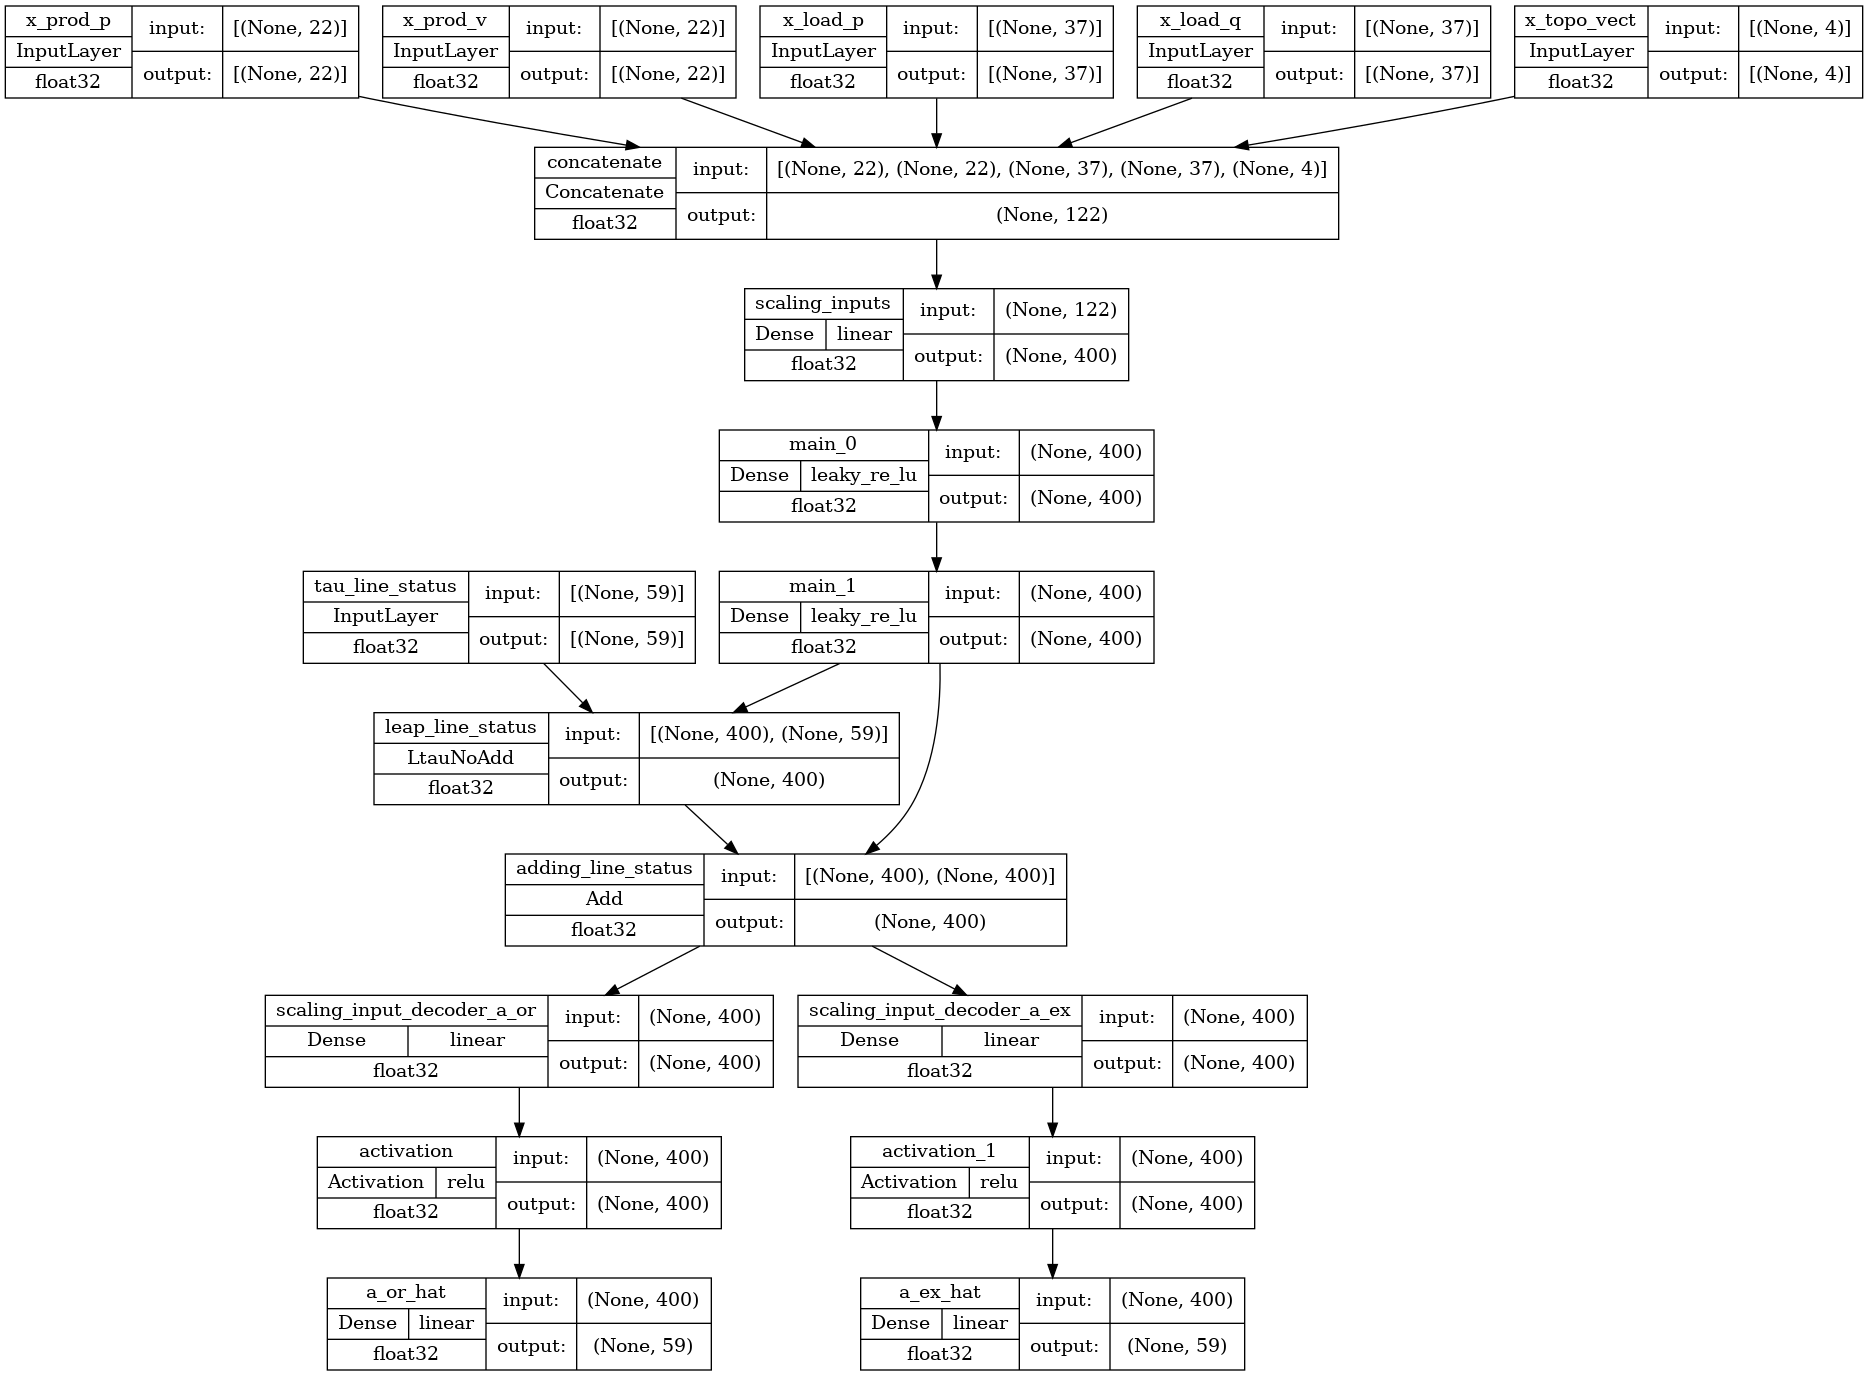

In [10]:
tf.keras.utils.plot_model(
    leap_net1._model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations= True)

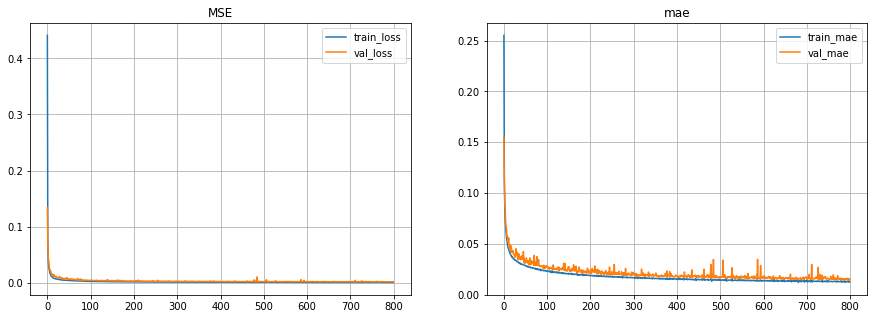

In [11]:
leap_net1.visualize_convergence()

In [12]:
tf_leapnet_metrics1 = benchmark1.evaluate_simulator(augmented_simulator=leap_net1,
                                              eval_batch_size=128,
                                              dataset="all",
                                              shuffle=False,
                                              save_predictions=True
                                             )

/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/venv/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_trafo.py:65: UserWarning: There were some Nan in the pp_net.trafo["tap_step_degree"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_step_degree\"], they have been replaced by 0")
/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/venv/lib/python3.8/site-packages/lightsim2grid/gridmodel/_aux_add_slack.py:113: UserWarning: We found either some slack coefficient to be < 0. or they were all 0.We set them all to 1.0 to avoid such issues
  warnings.warn("We found either some slack coefficient to be < 0. or they were all 0."


1/1 [==============================] - 0s 37ms/step


/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/getting_started/training baselines /../../lips/benchmark/powergridBenchmark.py:351: UserWarning: You indicate to save the predictions, without providing a path. No predictions will be saved!
  warnings.warn(message="You indicate to save the predictions, without providing a path. No predictions will be saved!")


1/1 [==============================] - 0s 37ms/step


/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/getting_started/training baselines /../../lips/benchmark/powergridBenchmark.py:351: UserWarning: You indicate to save the predictions, without providing a path. No predictions will be saved!
  warnings.warn(message="You indicate to save the predictions, without providing a path. No predictions will be saved!")


3/3 [==============================] - 0s 9ms/step


/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/getting_started/training baselines /../../lips/benchmark/powergridBenchmark.py:351: UserWarning: You indicate to save the predictions, without providing a path. No predictions will be saved!
  warnings.warn(message="You indicate to save the predictions, without providing a path. No predictions will be saved!")


In [13]:
SAVE_PATH = get_path(TRAINED_BASELINES_PATH, benchmark1)
leap_net1.save(SAVE_PATH)


In [14]:
import numpy as np
eval_metrics = tf_leapnet_metrics1

print("ML : MAPE90 --> A : mean :{}, std :{}".format(np.mean(list(eval_metrics["test"]["ML"]["mape_90_avg"].values())), np.std(list(eval_metrics["test"]["ML"]["mape_90_avg"].values()))))
print("ML : Inf speed-up :", eval_metrics["test"]["ML"]["TIME_INF"])
print("Rediness : Inf speed-up :", eval_metrics["test"]["IndRed"]["TIME_INF"])
print("OOD : MAPE90 --> A : mean :{}, std :{}".format(np.mean(list(eval_metrics["test_ood_topo"]["ML"]["mape_90_avg"].values())), np.std(list(eval_metrics["test_ood_topo"]["ML"]["mape_90_avg"].values()))))



ML : MAPE90 --> A : mean :0.0049590070149185365, std :8.418010583453005e-06
ML : Inf speed-up : 0.3658362890128046
Rediness : Inf speed-up : 0.3749981439905241
OOD : MAPE90 --> A : mean :0.04321483653814799, std :0.00013422264017170366


In [15]:
testset_violoation = [eval_metrics["test"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"], eval_metrics["test"]["Physics"]["CURRENT_POS"]["a_ex"]["Violation_proportion"]]
print("Physics : test --> CURRENT_POS : mean :{}, std :{}".format(np.mean(testset_violoation), np.std(testset_violoation)))

oodset_violoation = [eval_metrics["test_ood_topo"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"], eval_metrics["test_ood_topo"]["Physics"]["CURRENT_POS"]["a_ex"]["Violation_proportion"]]
print("Physics : ood --> CURRENT_POS : mean :{}, std :{}".format(np.mean(oodset_violoation), np.std(oodset_violoation)))


Physics : test --> CURRENT_POS : mean :0.008703898305084746, std :0.0002889830508474578
Physics : ood --> CURRENT_POS : mean :0.013013785310734462, std :0.0003535593220338985
